In [1]:
import itertools
import os
import pickle
import random
from multiprocessing import Pool
from typing import Any, Callable, Dict, Iterable, Iterator, List, Optional, Tuple, Union

# import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from tqdm import tqdm

from replay_loading import enum_replay_folder, files_to_strokes, sample_stroke

%matplotlib inline
plt.style.use("ggplot")

In [2]:
replay_fns = list(itertools.islice(enum_replay_folder("H:/osu!/Data/r/"), 300))
strokes_subset = list(files_to_strokes(tqdm(replay_fns), min_length=50))
sum((len(s[0]) for s in strokes_subset))

100%|██████████| 300/300 [00:17<00:00, 17.38it/s]


1930021

In [3]:
# all_replays = list(enum_replay_folder("H:/osu!/Data/r/"))
# all_strokes = list(files_to_strokes(tqdm(all_replays), min_length=50))
# pickle.dump(all_strokes, open("all_strokes.pkl", "wb"))

In [3]:
all_strokes = pickle.load(open("all_strokes.pkl", "rb"))

In [5]:
class StrokeDataset(Dataset):
    def __init__(self, strokes, transforms=None):
        self.strokes = strokes
        self.transforms = transforms
        self.wrand_sampler = WeightedRandomSampler([len(s[0]) for s in strokes], len(strokes), replacement=True)

    def __len__(self):
        return len(self.strokes)

    def __getitem__(self, idx):
        sample = self.strokes[idx]
        
        # Apply the transformations if any
        if self.transforms:
            for transform in self.transforms:
                sample = transform(sample)
            return sample
        else:
            return sample[1]


class StrokeResample:
    def __init__(self, rate_range=(30, 250), max_length=2048):
        self.rate_range = rate_range
        self.max_length = max_length

    def __call__(self, sample):
        timings, positions = sample
        rate = np.random.uniform(*self.rate_range)
        offset = np.random.uniform(0, 1/rate)
        return sample_stroke(timings, positions, rate, offset, max_length=self.max_length)


class StrokeDiff:
    def __call__(self, sample):
        return np.diff(sample, axis=0)


class ScaleRotateFlip:
    def __init__(self, scale_range=(0.5, 1.5)):
        self.scale_range = scale_range

    def __call__(self, sample):
        scale = random.uniform(*self.scale_range)
        sample = sample * scale
        angle = random.uniform(-np.pi, np.pi)
        flip = random.choice([1, -1])
        rotation_matrix = np.array([
            [np.cos(angle), -flip * np.sin(angle)],
            [flip * np.sin(angle), np.cos(angle)]])
        sample = sample @ rotation_matrix
        return sample


class StrokeToTensor:
    def __call__(self, sample):
        return torch.from_numpy(sample).float()


def collate_pad_beginning_zeroes(batch):
    max_len = max([len(stroke) for stroke in batch])
    padded_batch = [F.pad(stroke, (0, 0, max_len - len(stroke), 0)) for stroke in batch]
    return torch.stack(padded_batch)


transforms = [
    StrokeResample(max_length=4096),
    StrokeDiff(),
    ScaleRotateFlip(),
    StrokeToTensor(),
]

batch_size = 1024

ds_small = StrokeDataset(strokes_subset, transforms=transforms)
ds_small_loader = DataLoader(ds_small, batch_size=batch_size, sampler=ds_small.wrand_sampler, collate_fn=collate_pad_beginning_zeroes)

ds_full = StrokeDataset(all_strokes, transforms=transforms)
ds_full_loader = DataLoader(ds_full, batch_size=batch_size, sampler=ds_full.wrand_sampler, collate_fn=collate_pad_beginning_zeroes)

In [28]:

class TestNet3(torch.jit.ScriptModule):
    def __init__(
        self, kernels=[5] * 12, channels=[8] * 4 + [4] * 4 + [2] * 4, dilations=None
    ):
        super().__init__()

        self.kernels = torch.tensor(kernels + [1])
        self.channels = torch.tensor(channels + [2])
        self.in_channels = torch.tensor([2] + channels).cumsum(dim=0)
        self.total_channels = self.in_channels[-1].item() + 2
        self.dilations = torch.tensor(dilations + [1]) if dilations is not None else None
        self.pads = (self.kernels - 1) * (self.dilations if self.dilations is not None else 1)
        self.pad_total = self.pads.sum().item()
        self.pad_max = self.pads.max().item()
        self.ar_len = 5

        self.convs = nn.ModuleList(
            [
                nn.Conv1d(
                    in_channels=self.in_channels[i].item(),
                    out_channels=self.channels[i].item() * 2,
                    kernel_size=self.kernels[i].item(),
                    dilation=self.dilations[i].item() if self.dilations is not None else 1,
                )
                for i in range(len(self.kernels))
            ]
        )
        self.n_layers = len(self.convs)

        print(f"Kernels: {self.kernels}")
        print(f"Input channels: {self.in_channels}")
        print(f"Channels: {self.channels}")
        print(f"Dilations: {self.dilations}")
        print(f"Pads: {self.pads}")
        print(f"Total padding: {self.pad_total}")

    @torch.jit.script_method
    def forward(self, x):
        # input is (batch, seq_len, 2)
        # x = x.mT  # (batch, 2, seq_len)
        curr_window = torch.tensor(x.shape[-1])
        acts = [x]
        for i, conv in enumerate(self.convs):
            x = torch.cat([act[..., -curr_window:] for act in acts], dim=1)
            x = conv(x)
            x = F.glu(x, dim=1)
            curr_window -= self.pads[i]
            acts.append(x)
        return x

    def forward_ar(self, x):
        batch_size = torch.tensor(x.shape[0])
        seq_len = torch.tensor(x.shape[-1])
        acts = torch.empty(
            batch_size,
            self.total_channels,
            seq_len + self.ar_len - 1,
            device=x.device,
        )
        acts[..., :2, :seq_len] = x
        # first pass
        curr_window = seq_len.clone()
        for i, conv in enumerate(self.convs):
            channel_start = self.in_channels[i]
            channel_end = channel_start + self.channels[i]
            x = acts[..., :channel_start, seq_len - curr_window : seq_len]
            x = conv(x)
            x = F.glu(x, dim=-2)
            curr_window -= self.pads[i]
            acts[
                ...,
                channel_start:channel_end,
                seq_len - curr_window : seq_len,
            ] = x
        # later autoregressive passes
        for ar_step in range(1, self.ar_len):
            step_col = seq_len + ar_step - 1
            acts[..., :2, step_col] = acts[..., -2:, step_col - 1]
            for i, conv in enumerate(self.convs):
                channel_start = self.in_channels[i]
                channel_end = channel_start + self.channels[i]
                x = acts[
                    ...,
                    :channel_start,
                    step_col - self.pads[i] - 1 : step_col,
                ]
                x = conv(x)
                x = F.glu(x, dim=-2)
                acts[
                    ...,
                    channel_start:channel_end,
                    step_col : step_col + 1,
                ] = x
        return acts[..., -2:, -self.ar_len :]  # .mT
    
    # @torch.jit.script_method
    def forward_ar_jit(self, x):
        batch_size = torch.tensor(x.shape[0])
        seq_len = torch.tensor(x.shape[-1])
        acts = [x]
        # first pass
        curr_window = seq_len.clone()
        for i, conv1 in enumerate(self.convs):
            x = torch.cat([act[..., -curr_window:] for act in acts], dim=1)
            x = conv1(x)
            x = F.glu(x, dim=1)
            curr_window -= self.pads[i]
            acts.append(x)
        # print([act[..., -self.pad_max:].shape for act in acts])
        # acts = torch.cat([act[..., -self.pad_max:] for act in acts], dim=1)
        res = [acts[:, -2:, -1]]
        # later autoregressive passes
        for ar_step in range(1, self.ar_len):
            # step_col = seq_len + ar_step - 1
            step_acts = [res[-1]]
            for i, conv2 in enumerate(self.convs):
                x = torch.cat([acts[:, :self.in_channels[i], -self.pads[i]:], torch.cat(step_acts, dim=1)], dim=2)
                x = conv2(x)
                x = F.glu(x, dim=1)
                step_acts.append(x)
            res.append(step_acts[-1])
            acts = torch.cat([acts[..., 1:], torch.cat(step_acts, dim=1)], dim=2)
        return torch.stack(res, dim=-1)


sum(p.numel() for p in TestNet3().parameters() if p.requires_grad)

Kernels: tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1])
Input channels: tensor([ 2, 10, 18, 26, 34, 38, 42, 46, 50, 52, 54, 56, 58])
Channels: tensor([8, 8, 8, 8, 4, 4, 4, 4, 2, 2, 2, 2, 2])
Dilations: None
Pads: tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0])
Total padding: 48


15468

In [43]:
x1 = torch.tensor(8)
x2 = x1.clone()
x2-= 9
x1, x2

(tensor(8), tensor(-1))

In [44]:
torch.arange(10)[-2:10]

tensor([8, 9])

In [45]:
smaller_params = {
    "kernels": [8, 6, 4, 3, 2],
    "channels": [2]*5
}

smaller_model = TestNet3(**smaller_params)

sum(p.numel() for p in smaller_model.parameters() if p.requires_grad), smaller_model.pad_total

Kernels: tensor([8, 6, 4, 3, 2, 1])
Input channels: tensor([ 2,  4,  6,  8, 10, 12])
Channels: tensor([2, 2, 2, 2, 2, 2])
Dilations: None
Pads: tensor([7, 5, 3, 2, 1, 0])
Total padding: 18


(504, 18)

In [46]:
small_params = {
    "kernels": [5]*6,
    "channels": [2]*6,
    "dilations": [1, 2, 3, 4, 2, 1]
}

small_model = TestNet3(**small_params)

sum(p.numel() for p in small_model.parameters() if p.requires_grad), small_model.pad_total

Kernels: tensor([5, 5, 5, 5, 5, 5, 1])
Input channels: tensor([ 2,  4,  6,  8, 10, 12, 14])
Channels: tensor([2, 2, 2, 2, 2, 2, 2])
Dilations: tensor([1, 2, 3, 4, 2, 1, 1])
Pads: tensor([ 4,  8, 12, 16,  8,  4,  0])
Total padding: 52


(924, 52)

In [47]:
dilated2_params = {
    "kernels": [5]*7,
    "channels": [4, 4, 3, 3, 2, 2, 2],
    "dilations": [1, 2, 3, 4, 3, 2, 1]
}

dilated2_model = TestNet3(**dilated2_params)

sum(p.numel() for p in dilated2_model.parameters() if p.requires_grad), dilated2_model.pad_total

Kernels: tensor([5, 5, 5, 5, 5, 5, 5, 1])
Input channels: tensor([ 2,  6, 10, 13, 16, 18, 20, 22])
Channels: tensor([4, 4, 3, 3, 2, 2, 2, 2])
Dilations: tensor([1, 2, 3, 4, 3, 2, 1, 1])
Pads: tensor([ 4,  8, 12, 16, 12,  8,  4,  0])
Total padding: 64


(2222, 64)

In [48]:
dilated3_params = {
    "kernels": [7]*7+[6],
    "channels": [4, 4, 4, 4, 2, 2, 2, 2],
    "dilations": [1, 4, 6, 10, 10, 6, 4, 1]
}

dilated3_model = TestNet3(**dilated3_params)

sum(p.numel() for p in dilated3_model.parameters() if p.requires_grad), dilated3_model.pad_total

Kernels: tensor([7, 7, 7, 7, 7, 7, 7, 6, 1])
Input channels: tensor([ 2,  6, 10, 14, 18, 20, 22, 24, 26])
Channels: tensor([4, 4, 4, 4, 2, 2, 2, 2, 2])
Dilations: tensor([ 1,  4,  6, 10, 10,  6,  4,  1,  1])
Pads: tensor([ 6, 24, 36, 60, 60, 36, 24,  5,  0])
Total padding: 251


(4204, 251)

In [11]:
# dilated4_params = {
#     "kernels": [3, 3, 4, 4, 5, 5, 6, 6],
#     "channels": [4, 4, 3, 3, 2, 2, 1, 1],
#     "dilations": [1, 1, 2, 4, 6, 8, 10, 12]
# }
dilated4_params = {
    "kernels": [7, 7, 7, 5, 5, 5, 3, 3, 3],
    "channels": [4, 4, 4, 3, 3, 3, 1, 1, 1],
    "dilations": [1, 2, 8, 12, 16, 12, 8, 2, 1],
}

dilated4_model = TestNet3(**dilated4_params)

# init all biases to 0
for m in dilated4_model.modules():
    if isinstance(m, nn.Conv1d):
        m.bias.data.zero_()


(
    sum(p.numel() for p in dilated4_model.parameters() if p.requires_grad),
    dilated4_model.pad_total,
)


Kernels: tensor([7, 7, 7, 5, 5, 5, 3, 3, 3, 1])
Input channels: tensor([ 2,  6, 10, 14, 17, 20, 23, 24, 25, 26])
Channels: tensor([4, 4, 4, 3, 3, 3, 1, 1, 1, 2])
Dilations: tensor([ 1,  2,  8, 12, 16, 12,  8,  2,  1,  1])
Pads: tensor([ 6, 12, 48, 48, 64, 48, 16,  4,  2,  0])
Total padding: 248


(3126, 248)

In [73]:
model = dilated4_model.cuda()
unpad = model.pad_total + 1
optimizer = optim.AdamW(model.parameters(), lr=0.005)

losses = []
losses_verbose = []

100%|██████████| 219/219 [01:51<00:00,  1.96it/s]


Epoch 1, Loss: 0.5033286178493064, LR: 0.005


100%|██████████| 219/219 [01:51<00:00,  1.96it/s]


Epoch 2, Loss: 0.38214694569099983, LR: 0.004969282409784869


100%|██████████| 219/219 [01:51<00:00,  1.97it/s]


Epoch 3, Loss: 0.3659466698289462, LR: 0.004877886008156408


100%|██████████| 219/219 [01:51<00:00,  1.96it/s]


Epoch 4, Loss: 0.3564784242410094, LR: 0.004728061277849978


100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Epoch 5, Loss: 0.35366976410830947, LR: 0.004523497400965494


100%|██████████| 219/219 [01:52<00:00,  1.94it/s]


Epoch 6, Loss: 0.3505887469472406, LR: 0.004269231419060436


100%|██████████| 219/219 [01:52<00:00,  1.95it/s]


Epoch 7, Loss: 0.3470866908765819, LR: 0.00397152420446972


100%|██████████| 219/219 [01:50<00:00,  1.98it/s]


Epoch 8, Loss: 0.34482313549681887, LR: 0.0036377062968501695


100%|██████████| 219/219 [01:50<00:00,  1.99it/s]


Epoch 9, Loss: 0.3434695118366311, LR: 0.0032759974009654944


100%|██████████| 219/219 [01:48<00:00,  2.02it/s]


Epoch 10, Loss: 0.3455778790391199, LR: 0.0028953039902753766


100%|██████████| 219/219 [01:49<00:00,  1.99it/s]


Epoch 11, Loss: 0.3413932738510985, LR: 0.0025050000000000003


100%|██████████| 219/219 [01:51<00:00,  1.96it/s]


Epoch 12, Loss: 0.3412224732033194, LR: 0.002114696009724625


100%|██████████| 219/219 [01:51<00:00,  1.96it/s]


Epoch 13, Loss: 0.34027855472477603, LR: 0.0017340025990345066


100%|██████████| 219/219 [01:50<00:00,  1.99it/s]


Epoch 14, Loss: 0.3399965980825903, LR: 0.001372293703149831


100%|██████████| 219/219 [01:50<00:00,  1.98it/s]


Epoch 15, Loss: 0.34245839238711145, LR: 0.00103847579553028


100%|██████████| 219/219 [01:51<00:00,  1.96it/s]


Epoch 16, Loss: 0.3406832905392669, LR: 0.0007407685809395642


100%|██████████| 219/219 [01:51<00:00,  1.97it/s]


Epoch 17, Loss: 0.3395968001999267, LR: 0.00048650259903450645


100%|██████████| 219/219 [01:50<00:00,  1.98it/s]


Epoch 18, Loss: 0.34061274898650984, LR: 0.0002819387221500224


100%|██████████| 219/219 [01:50<00:00,  1.98it/s]


Epoch 19, Loss: 0.34042032001769706, LR: 0.00013211399184359196


100%|██████████| 219/219 [01:50<00:00,  1.98it/s]


Epoch 20, Loss: 0.3396178048495288, LR: 4.0717590215131546e-05


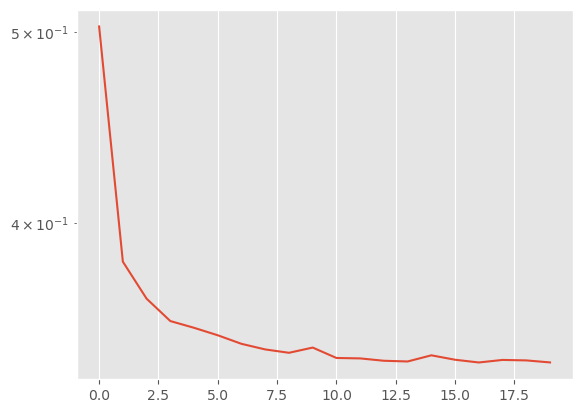

In [74]:
n_epochs = 20
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=0.00001)

for m in dilated4_model.modules():
    if isinstance(m, nn.Conv1d):
        m.bias.requires_grad = False

for epoch in range(n_epochs):  # number of epochs
    epoch_losses = []

    if epoch == 1:
        for m in dilated4_model.modules():
            if isinstance(m, nn.Conv1d):
                m.bias.requires_grad = True

    for batch in tqdm(ds_full_loader):
        # Zero the gradients
        optimizer.zero_grad()

        batch = batch.cuda()
        input_tensor = batch[:, :-1, :].mT
        target_tensor = batch[:, unpad:, :].mT

        # Forward pass
        outputs = model(input_tensor)

        # Compute loss
        loss = F.huber_loss(outputs, target_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    
    epoch_loss = np.mean(epoch_losses)
    losses.append(epoch_loss)
    losses_verbose.append(epoch_losses)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}, LR: {scheduler.get_last_lr()[0]}")

    # Update the learning rate
    scheduler.step()

plt.plot(losses)
plt.yscale('log')

In [86]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [85]:
model.cpu()
# torch.save(model.state_dict(), "model1.pth")

TestNet3(
  (convs): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(original_name=Conv1d)
    (1): RecursiveScriptModule(original_name=Conv1d)
    (2): RecursiveScriptModule(original_name=Conv1d)
    (3): RecursiveScriptModule(original_name=Conv1d)
    (4): RecursiveScriptModule(original_name=Conv1d)
    (5): RecursiveScriptModule(original_name=Conv1d)
    (6): RecursiveScriptModule(original_name=Conv1d)
    (7): RecursiveScriptModule(original_name=Conv1d)
    (8): RecursiveScriptModule(original_name=Conv1d)
    (9): RecursiveScriptModule(original_name=Conv1d)
  )
)

In [17]:
# model = TestNet3()
# model.load_state_dict(torch.load("model1.pth"))
# model, model.pad_total

In [29]:
# torch.save(model.state_dict(), "dilated4_model.pth")
model = TestNet3(**dilated4_params)
model.load_state_dict(torch.load("dilated4_model.pth"))
model, model.pad_total

Kernels: tensor([7, 7, 7, 5, 5, 5, 3, 3, 3, 1])
Input channels: tensor([ 2,  6, 10, 14, 17, 20, 23, 24, 25, 26])
Channels: tensor([4, 4, 4, 3, 3, 3, 1, 1, 1, 2])
Dilations: tensor([ 1,  2,  8, 12, 16, 12,  8,  2,  1,  1])
Pads: tensor([ 6, 12, 48, 48, 64, 48, 16,  4,  2,  0])
Total padding: 248


(TestNet3(
   (convs): RecursiveScriptModule(
     original_name=ModuleList
     (0): RecursiveScriptModule(original_name=Conv1d)
     (1): RecursiveScriptModule(original_name=Conv1d)
     (2): RecursiveScriptModule(original_name=Conv1d)
     (3): RecursiveScriptModule(original_name=Conv1d)
     (4): RecursiveScriptModule(original_name=Conv1d)
     (5): RecursiveScriptModule(original_name=Conv1d)
     (6): RecursiveScriptModule(original_name=Conv1d)
     (7): RecursiveScriptModule(original_name=Conv1d)
     (8): RecursiveScriptModule(original_name=Conv1d)
     (9): RecursiveScriptModule(original_name=Conv1d)
   )
 ),
 248)

In [17]:
x = torch.zeros(1, model.pad_total + 1, 2)
x[:, -1, :] = torch.tensor([1, 1])
# x[:, -2, :] = torch.tensor([-0.05, 0.05])
# x[:, -1, :] = torch.tensor([-0.1, 0.1])
x = x.mT

model.ar_len = 5
with torch.no_grad():
    res = model.forward_ar(x)
res, x.shape, res.shape

(tensor([[[1.9452, 1.9452, 2.0111, 1.5037, 2.0517],
          [1.9527, 1.9527, 2.0368, 3.2496, 2.8725]]]),
 torch.Size([1, 2, 249]),
 torch.Size([1, 2, 5]))

In [30]:
with torch.no_grad():
    res = model.forward_ar_jit(x)
res, x.shape, res.shape

[torch.Size([1, 2, 64]), torch.Size([1, 4, 64]), torch.Size([1, 4, 64]), torch.Size([1, 4, 64]), torch.Size([1, 3, 64]), torch.Size([1, 3, 64]), torch.Size([1, 3, 23]), torch.Size([1, 1, 7]), torch.Size([1, 1, 3]), torch.Size([1, 1, 1]), torch.Size([1, 2, 1])]


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 64 but got size 23 for tensor number 6 in the list.

In [35]:
model.cpu()
x = x.cpu()

In [83]:
%timeit with torch.no_grad(): model.forward_ar(x)

9.71 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
optimized_model = torch.jit.trace(model, x)
%timeit with torch.no_grad(): optimized_model(x)

C:\Users\Abstract\AppData\Local\Temp\ipykernel_3740\2265697626.py:43: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  batch_size = torch.tensor(x.shape[0])
C:\Users\Abstract\AppData\Local\Temp\ipykernel_3740\2265697626.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_size = torch.tensor(x.shape[0])
C:\Users\Abstract\AppData\Local\Temp\ipykernel_3740\2265697626.py:44: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every 

2.99 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
torch.onnx.export(model, x, "dilated4_ar5steps.onnx")

C:\Users\Abstract\AppData\Local\Temp\ipykernel_3740\2265697626.py:43: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  batch_size = torch.tensor(x.shape[0])
C:\Users\Abstract\AppData\Local\Temp\ipykernel_3740\2265697626.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_size = torch.tensor(x.shape[0])
C:\Users\Abstract\AppData\Local\Temp\ipykernel_3740\2265697626.py:44: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every 

In [224]:
def autoregressive_call(x):
    res = x
    n = 5
    for i in range(n):
        res = torch.cat([res[:,1:,:], model(res)[:,-1:,:]], dim=1)
    return res[:, -n:, :]

In [ ]:
torch.onnx.export(autoregressive_call, x, "dilated2_ar.onnx")

In [225]:
autoregressive_call(x)

tensor([[[-0.1185,  0.1132],
         [-0.1234,  0.1060],
         [-0.1334,  0.1007],
         [-0.1505,  0.1039],
         [-0.1711,  0.1115]]], grad_fn=<SliceBackward0>)

In [ ]:
torch.export.export(model, (x,))

In [13]:
torch.onnx.export(model, x, "model1.onnx")#, verbose=True)

In [18]:
torch.onnx.export(model, torch.rand(4, 49, 2), "model2.onnx")

In [ ]:
torch.onnx.dynamo_export(model, x, export_options=torch.onnx.ExportOptions(dynamic_shapes=True)).save("model3.onnx")